In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/humonics/.fastai/data/camvid/labels'),
 PosixPath('/home/humonics/.fastai/data/camvid/images'),
 PosixPath('/home/humonics/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/humonics/.fastai/data/camvid/valid.txt')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/humonics/.fastai/data/camvid/images/0006R0_f02790.png'),
 PosixPath('/home/humonics/.fastai/data/camvid/images/Seq05VD_f03210.png'),
 PosixPath('/home/humonics/.fastai/data/camvid/images/0006R0_f01200.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/humonics/.fastai/data/camvid/labels/0016E5_08057_P.png'),
 PosixPath('/home/humonics/.fastai/data/camvid/labels/0001TP_008130_P.png'),
 PosixPath('/home/humonics/.fastai/data/camvid/labels/0006R0_f03210_P.png')]

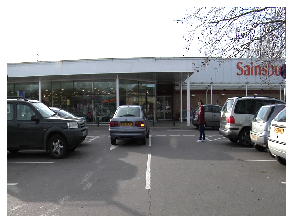

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

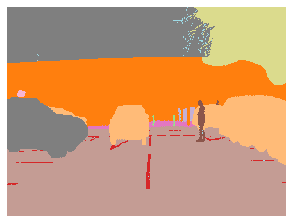

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 1309MB of GPU RAM free


In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

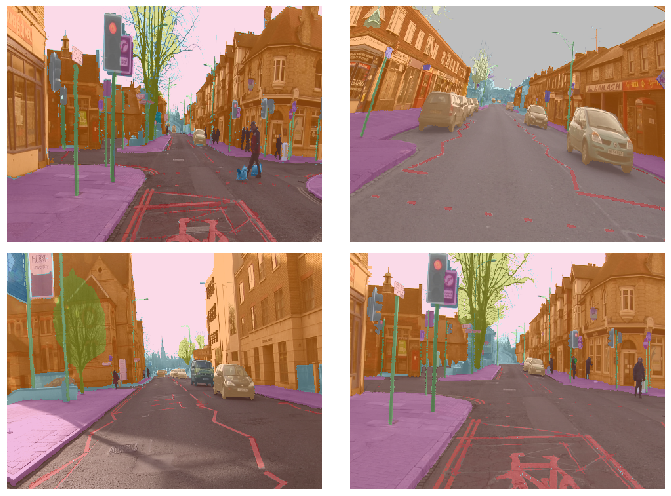

In [14]:
data.show_batch(2, figsize=(10,7))

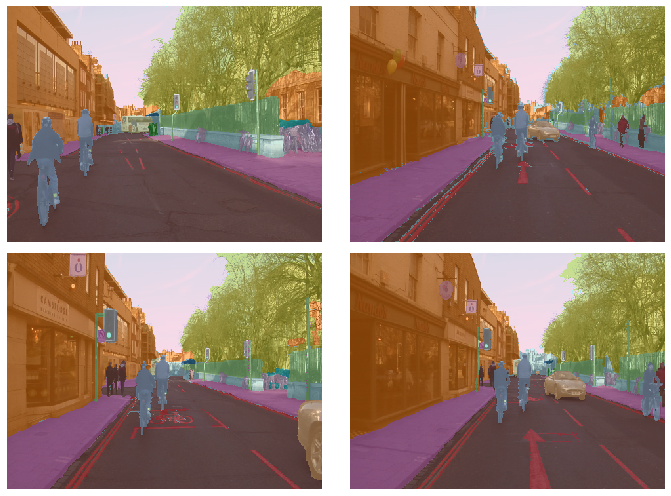

In [15]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics=acc_camvid
# metrics=accuracy

In [18]:
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [20]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 635.56 MiB already allocated; 27.19 MiB free; 22.44 MiB cached)

In [22]:
lr=3e-3

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 635.56 MiB already allocated; 26.94 MiB free; 22.44 MiB cached)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go Big

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

    To read more about different architectures of Semantic Segmentation:-
    https://www.topbots.com/semantic-segmentation-guide/